### Your very own neural network

In this notebook, we're going to build a neural network using naught but pure numpy and your willpower.

In [ ]:
# you may need this to download auxiliary code
! curl https://gist.githubusercontent.com/new-okaerinasai/2e212dccb0fbf019eb4b8a3d42dbf033/raw/9af114412393f1783ba29b78b20bdc2b7bc25abb/util.py  > util.py
! curl https://gist.githubusercontent.com/new-okaerinasai/a4026e0afe374b7371bd06d8138f4ac4/raw/df9074f6e4eb6e5eccaabc6e15b079b2261c0be9/mnist.py > mnist.py

from __future__ import print_function
import numpy as np
np.random.seed(42)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3782  100  3782    0     0  28870      0 --:--:-- --:--:-- --:--:-- 28651
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3421  100  3421    0     0  35268      0 --:--:-- --:--:-- --:--:-- 35268


### Recap: derivatives.

From your calculus course you know about derivatives:
\begin{gather*}
    \cfrac{\partial e^x}{\partial x} = e^x \\
    \cfrac{\partial x^2}{\partial x} = 2x \\
    \cfrac{\partial kx}{\partial x} = k
\end{gather*}

For backpropagation things go a bit more complicated...

A **composite function** is a function of a function.<br>If $u$ is a function of $x$, i.e. $u=u(x)$, and $f$ is a function of $u$:  $f=f(u)$, the function $y(x) = f(u(x))$ is composite.

For a composite function $f(z_1(x), z_2(x), \ldots, z_m(x))$ the derivative w.r.t. a single number $x$ is calculated as follows:
$$
    \cfrac{\partial f}{\partial x} = \sum_{i=1}^m \cfrac{\partial f}{\partial z_i} \cfrac{\partial z_i}{\partial x}
$$

$$
    \cfrac{\partial f(u(x))}{\partial x} = \cfrac{\partial f(u(x))}{\partial u(x)} \cdot \cfrac{\partial u(x)}{\partial x}
$$

In case of neural networks $z_i$'s may be outputs of the NN (or its intermidiate layer) for $m$ objects in a batch and $f$ may be the loss function and $x$ may be a single neuron weight (or bias). $x$ may also represent one element of the input of the NN (or its intermidiate layer).

So to **backpropagate** through the layer, you need to have pre-computed gradients w.r.t. the outputs of the layer ($\partial f / \partial z_i$'s) and you need to do two things: calculate gradients w.r.t. every single weight in the layer (if there are any) and w.r.t. inputs. This gradient will be passed as an input to the previous layer of the network.

Here goes our main class: a layer that can .forward() and .backward().

In [ ]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:
    
    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

### The road ahead

We're going to build a neural network that classifies MNIST digits. To do so, we'll need a few building blocks:
- Dense layer - a fully-connected layer, $f(X)=X \cdot W + \vec{b}$
- ReLU layer (or any other nonlinearity you want)
- Loss function - crossentropy
- Backprop algorithm - a stochastic gradient descent with backpropageted gradients

Let's approach them one at a time.


$$
    ReLU(x) = \begin{cases}
      0, x < 0\\
      x, x \geq 0
    \end{cases}
$$

### Nonlinearity layer

This is the simplest layer you can get: it simply applies a nonlinearity to each element of input.

In [ ]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        # <your code. Try np.maximum>
        output = np.where(input > 0, input, 0)
        return output
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad

In [ ]:
# some tests
from util import eval_numerical_gradient
x = np.linspace(-1,1,10*32).reshape([10,32])
l = ReLU()
grads = l.backward(x,np.ones([10,32])/(32*10))
numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).mean(), x=x)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0),\
    "gradient returned by your layer does not match the numerically computed gradient"

#### Instant primer: lambda functions

In python, you can define functions in one line using the `lambda` syntax: `lambda param1, param2: expression`

For example: `f = lambda x, y: x+y` is equivalent to a normal function:

```
def f(x,y):
    return x+y
```
For more information, click [here](http://www.secnetix.de/olli/Python/lambda_functions.hawk).    

### Dense layer

Now let's build something more complicated. Unlike nonlinearity, a dense layer actually has something to learn.

A dense layer applies affine transformation. In a vectorized form, it can be described as:
$$f(X)= X \cdot W + \vec b $$

Where 
* X is an object-feature matrix of shape [batch_size, num_features],
* W is a weight matrix [num_features, num_outputs] 
* and b is a vector of num_outputs biases.

Both W and b are initialized during layer creation and updated each time backward is called.

In [ ]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <x*W> + b
        """
        self.learning_rate = learning_rate
        
        # initialize weights with small random numbers. We use normal initialization, 
        # but surely there is something better. Try this once you got it working: http://bit.ly/2vTlmaJ
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <x*W> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return input @ self.weights + self.biases[np.newaxis]
    
    def backward(self,input,grad_output):
        """
            input is the same as X
            self.weights is the same as W
            self.biases is the same as b
        """
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        # self.weights shape == [m, n]
        # grad_output == [batch, n]
        # grad_input == [batch, m]
        grad_input = grad_output @ self.weights.T
        # <your code>
        
        # compute gradient w.r.t. weights and biases
        grad_weights = input.T @ grad_output
        grad_biases = grad_output.sum(0)
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        # Here we perform a stochastic gradient descent step. 
        # Later on, you can try replacing that with something better.
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

### Testing the dense layer

Here we have a few tests to make sure your dense layer works properly. You can just run them, get 3 "well done"s and forget they ever existed.

... or not get 3 "well done"s and go fix stuff. If that is the case, here are some tips for you:
* Make sure you compute gradients for b as __sum of gradients over batch__, not mean over gradients. Grad_output is already divided by batch size.
* If you're debugging, try saving gradients in class fields, like "self.grad_w = grad_w" or print first 3-5 weights. This helps debugging.
* If nothing else helps, try ignoring tests and proceed to network training. If it trains alright, you may be off by something that does not affect network training.

In [ ]:
l = Dense(128, 150)

assert -0.05 < l.weights.mean() < 0.05 and 1e-3 < l.weights.std() < 1e-1,\
    "The initial weights must have zero mean and small variance. "\
    "If you know what you're doing, remove this assertion."
assert -0.05 < l.biases.mean() < 0.05, "Biases must be zero mean. Ignore if you have a reason to do otherwise."

# To test the outputs, we explicitly set weights with fixed values. DO NOT DO THAT IN ACTUAL NETWORK!
l = Dense(3,4)

x = np.linspace(-1,1,2*3).reshape([2,3])
l.weights = np.linspace(-1,1,3*4).reshape([3,4])
l.biases = np.linspace(-1,1,4)

assert np.allclose(l.forward(x),np.array([[ 0.07272727,  0.41212121,  0.75151515,  1.09090909],
                                          [-0.90909091,  0.08484848,  1.07878788,  2.07272727]]))
print("Well done!")

Well done!


In [ ]:
# To test the grads, we use gradients obtained via finite differences

from util import eval_numerical_gradient

x = np.linspace(-1,1,10*32).reshape([10,32])
l = Dense(32,64,learning_rate=0)

numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).sum(),x)
grads = l.backward(x,np.ones([10,64]))

assert np.allclose(grads,numeric_grads,rtol=1e-3,atol=0), "input gradient does not match numeric grad"
print("Well done!")

Well done!


In [ ]:
#test gradients w.r.t. params
def compute_out_given_wb(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    return l.forward(x)
    
def compute_grad_by_params(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    l.backward(x,np.ones([10,64]) / 10.)
    return w - l.weights, b - l.biases
    
w,b = np.random.randn(32,64), np.linspace(-1,1,64)

numeric_dw = eval_numerical_gradient(lambda w: compute_out_given_wb(w,b).mean(0).sum(),w )
numeric_db = eval_numerical_gradient(lambda b: compute_out_given_wb(w,b).mean(0).sum(),b )
grad_w,grad_b = compute_grad_by_params(w,b)

assert np.allclose(numeric_dw,grad_w,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
assert np.allclose(numeric_db,grad_b,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
print("Well done!")

Well done!


## Intro to PyTorch starts here

In [ ]:
! pip install torch torchvision 

In [ ]:
! nvidia-smi

Mon Mar 22 07:06:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import numpy as np


torch.linalg.inv(torch.eye(12, 12))
np.linalg.inv(np.eye(12, 12))

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [ ]:
# np.array
# torch.tensor

a = torch.tensor([1, 2, 3, 4]).float()

a.requires_grad = True
b = a @ a

In [ ]:
# t.backward()
# t is a single number tensor

a = torch.tensor([1, 2, 3, 4]).float()

a.requires_grad = True
b = a @ a

b.backward()

In [ ]:
c = torch.tensor([1, 2, 3, 4]).float()
c.requires_grad = True
a = torch.log(c * torch.ones_like(c))
s = a * 10
s.retain_grad()

b = s @ s
d = b * 3

e = c @ c
b.backward()
e.backward()

In [ ]:
c.grad

tensor([ 2.0000, 73.3147, 79.2408, 77.3147])

In [ ]:
from torch import nn

layer = nn.Linear(10, 20)

y_pred = layer.forward(torch.eye(2, 10))

criterion = nn.MSELoss()
y_true = torch.rand(2, 20)

loss = criterion(y_pred, y_true)

loss.backward()

In [ ]:
network = nn.Sequential(
    nn.Linear(10, 20),
    nn.ReLU(),
    nn.Linear(20, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

y_true = torch.rand(64, 1)
X = torch.rand(64, 10)
y_pred = network(X)

criterion = nn.MSELoss()
loss = criterion(y_pred, y_true)
loss.backward()

In [ ]:
for name, layer in network.named_modules():
    if isinstance(layer, nn.Linear):
        print(layer.weight.grad)
        # layer.weight.data -= learning_rate * layer.weight.grad

tensor([[-5.9227e-04, -1.2769e-03, -7.1916e-04, -1.2212e-03, -1.3676e-03,
         -1.5202e-04, -4.7838e-04, -1.5224e-04, -4.3640e-04, -6.2844e-04],
        [-1.7349e-03, -4.2877e-03, -4.5226e-03, -3.0557e-03, -2.7464e-03,
         -2.3834e-03, -6.2023e-03, -3.5022e-03, -4.6755e-03, -7.5143e-03],
        [ 5.2204e-03,  7.0774e-03,  4.3013e-03,  9.7894e-03,  4.5955e-03,
          1.7241e-03,  8.4501e-03,  3.2167e-03,  4.6464e-03,  8.2825e-03],
        [ 1.0515e-03,  1.1924e-03,  1.3178e-03,  3.8483e-04,  5.6472e-04,
          8.5060e-04,  5.1206e-04,  1.4272e-03,  1.8189e-04,  1.3569e-03],
        [ 5.8094e-02,  6.7417e-02,  5.8246e-02,  4.4520e-02,  7.5652e-02,
          6.3476e-02,  4.6033e-02,  5.4187e-02,  6.7366e-02,  5.9687e-02],
        [-2.2070e-02, -2.6214e-02, -3.1939e-02, -1.9938e-02, -2.3637e-02,
         -2.5798e-02, -2.4335e-02, -2.8884e-02, -2.4926e-02, -2.9422e-02],
        [ 4.0992e-02,  3.9312e-02,  4.0007e-02,  3.0853e-02,  4.6247e-02,
          3.5837e-02,  3.0126e-0

## Your "homework-1: part 1" starts here 

### The loss function

Since we want to predict probabilities, it would be logical for us to define softmax nonlinearity on top of our network and compute loss given predicted probabilities. However, there is a better way to do so.

If you write down the expression for crossentropy as a function of softmax logits (a), you'll see:

$$ loss = - log \space {e^{a_{correct}} \over {\underset i \sum e^{a_i} } } $$

If you take a closer look, ya'll see that it can be rewritten as:

$$ loss = - a_{correct} + log {\underset i \sum e^{a_i} } $$

It's called Log-softmax and it's better than naive log(softmax(a)) in all aspects:
* Better numerical stability
* Easier to get derivative right
* Marginally faster to compute

So why not just use log-softmax throughout our computation and never actually bother to estimate probabilities.

Here you are! We've defined the both loss functions for you so that you could focus on neural network part.

In [ ]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [ ]:
logits = np.linspace(-1,1,500).reshape([50,10])
answers = np.arange(50)%10

softmax_crossentropy_with_logits(logits,answers)
grads = grad_softmax_crossentropy_with_logits(logits,answers)
numeric_grads = eval_numerical_gradient(lambda l: softmax_crossentropy_with_logits(l,answers).mean(),logits)

assert np.allclose(numeric_grads,grads,rtol=1e-3,atol=0), "The reference implementation has just failed. Someone has just changed the rules of math."

### Full network

Now let's combine what we've just built into a working neural network. As we announced, we're gonna use this monster to classify handwritten digits, so let's get them loaded.

Done
Done
Done
Done
Converting wi5xou.gz to NumPy Array ...
Done
Converting 4kmilz.gz to NumPy Array ...
Done
Converting i07sei.gz to NumPy Array ...
Done
Converting aswuq5.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


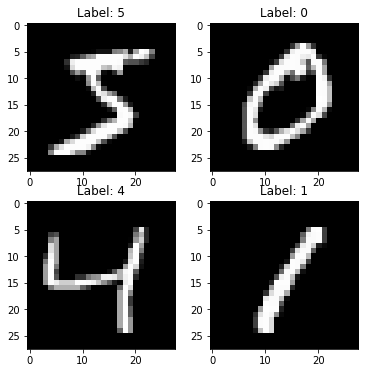

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from mnist import load_mnist
(X_train, y_train), (X_val, y_val) = load_mnist(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

We'll define network as a list of layers, each applied on top of previous one. In this setting, computing predictions and training becomes trivial.

In [ ]:
network = []
network.append(Dense(X_train.shape[1], 100))
network.append(ReLU())
network.append(Dense(100, 200))
network.append(ReLU())
network.append(Dense(200, 10))

In [ ]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X

    activations.append(input)
    for i in range(len(network)):
      activations.append( network[i].forward(activations[i]) )

    activations.pop(0)    
    assert len(activations) == len(network)
    return activations

def predict(network, X):
    """
    Use network to predict the most likely class for each sample.
    """
    logits = forward(network, X)[-1]
    return logits.argmax(axis=-1)

### Backprop

You can now define the backpropagation step for the neural network. Please read the docstring.

In [ ]:
def train(network,X,y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    You can estimate loss and loss_grad, obtaining dL / dy_pred
    Then you can run layer.backward going from last layer to first, 
    propagating the gradient of input to previous layers.
    
    After you called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X] + layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    
    # propagate gradients through network layers using .backward
    # hint: start from last layer and move to earlier layers
    
    #No need to store all grads. But we need current last one to go backward
    grad_output = loss_grad
    for i in reversed(range(len(network))):
      grad_output = network[i].backward(layer_inputs[i], grad_output)
        
    return np.mean(loss)

Instead of tests, we provide you with a training loop that prints training and validation accuracies on every epoch.

If your implementation of forward and backward are correct, your accuracy should grow from 90~93% to >97% with the default network.

### Training loop

As usual, we split data into minibatches, feed each such minibatch into the network and update weights.

In [ ]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [ ]:
from IPython.display import clear_output

Базовая сетка

Epoch 24
Train accuracy: 1.0
Val accuracy: 0.9811


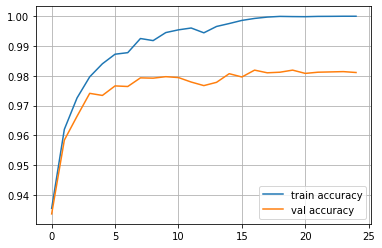

CPU times: user 2min 34s, sys: 1min 14s, total: 3min 49s
Wall time: 1min 59s


In [ ]:
%%time

network = []
network.append(Dense(X_train.shape[1], 100))
network.append(ReLU())
network.append(Dense(100, 200))
network.append(ReLU())
network.append(Dense(200, 10))

train_log = []
val_log = []

for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        train(network, x_batch, y_batch)
    
    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

__What should you see:__ `train accuracy` should increase to near-100%. Val accuracy will also increase, allbeit to a smaller value.

__What else to try:__ You can try implementing different nonlinearities, dropout or composing neural network of more layers. See how this affects training speed, overfitting & final quality.

Good hunting!

Везде идентичные условия обучения. Меняется лишь структура сети.

Epoch 24
Train accuracy: 0.9544666666666667
Val accuracy: 0.9424


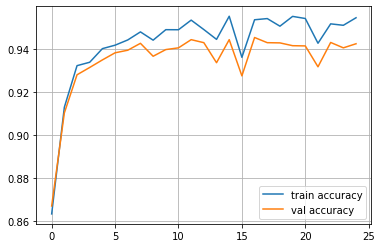

CPU times: user 32 s, sys: 3.73 s, total: 35.7 s
Wall time: 28.3 s


In [ ]:
%%time

network = []
network.append(Dense(X_train.shape[1], 10))
network.append(ReLU())
network.append(Dense(10, 20))
network.append(ReLU())
network.append(Dense(20, 10))

train_log = []
val_log = []

for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        train(network, x_batch, y_batch)
    
    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

Epoch 24
Train accuracy: 1.0
Val accuracy: 0.9818


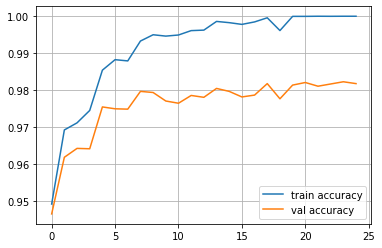

CPU times: user 7min 47s, sys: 2min 53s, total: 10min 40s
Wall time: 5min 44s


In [ ]:
%%time

network = []
network.append(Dense(X_train.shape[1], 100))
network.append(ReLU())
network.append(Dense(100, 2000))
network.append(ReLU())
network.append(Dense(2000, 10))

train_log = []
val_log = []

for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        train(network, x_batch, y_batch)
    
    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

Epoch 24
Train accuracy: 0.9914833333333334
Val accuracy: 0.973


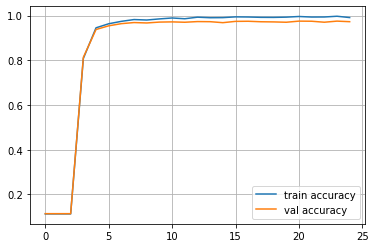

CPU times: user 6min 38s, sys: 2min 36s, total: 9min 15s
Wall time: 4min 51s


In [ ]:
%%time

network = []
network.append(Dense(X_train.shape[1], 100))
network.append(ReLU())
network.append(Dense(100, 200))
network.append(ReLU())
network.append(Dense(200, 300))
network.append(ReLU())
network.append(Dense(300, 400))
network.append(ReLU())
network.append(Dense(400, 10))

train_log = []
val_log = []

for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        train(network, x_batch, y_batch)
    
    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

Epoch 24
Train accuracy: 0.9996833333333334
Val accuracy: 0.9792


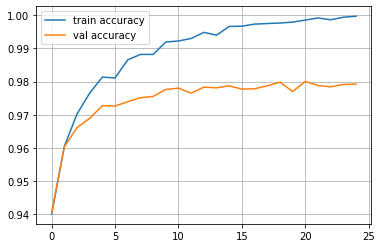

CPU times: user 2min 9s, sys: 55.2 s, total: 3min 5s
Wall time: 1min 37s


In [ ]:
%%time

network = []
network.append(Dense(X_train.shape[1], 100))
network.append(ReLU())
network.append(Dense(100, 10))

train_log = []
val_log = []

for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        train(network, x_batch, y_batch)
    
    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

Epoch 24
Train accuracy: 0.9999666666666667
Val accuracy: 0.982


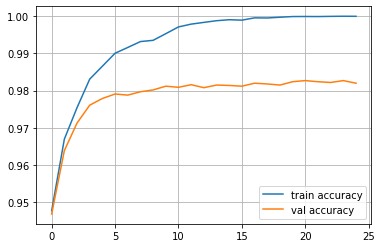

CPU times: user 14min 43s, sys: 3min 25s, total: 18min 8s
Wall time: 9min 32s


In [ ]:
%%time

network = []
network.append(Dense(X_train.shape[1], 1000))
network.append(ReLU())
network.append(Dense(1000, 10))

train_log = []
val_log = []

for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        train(network, x_batch, y_batch)
    
    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))
    
    clear_output()
    print("Epoch",epoch)и
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

Очень интересно выходит! Глобально нам не удалось улучшить резы. Локально - последний вариант самый сильный. Заметим, что в нем всего два полносвязных слоя, зато они потолще (теорема Цыбенко). 